In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# Logistic Regression: StatsModels and Details of Regression

We can do some more logitic regression to make classification predictions, there's some things that we do to try to drive accuracy up, and some other work we can do to interpret the accuracy better. 

In [ ]:
#Read diabetes data
df = pd.read_csv("data/diabetes.csv")
df.head()

### Baseline Accuracy

Before we get going, we'll touch on a simple concept - the baseline accuracy. For example, in post WW2 Germany the ratio of males to females was approximately .6 (3:5) for people in their 20s - or approximately 5/8 or 62.5% of people were females. 

If we were to build some model to predict if a twenty-soemthing was a male or female, this should be the worst we can do. A 'default' model of always guessing female will be 62.5% accurate, so if we can't beat that, we suck and are useless. 

In [ ]:
#baseline for diabetes
1 - df["Outcome"].mean()

So... a model guessing NO at all times would be ~65% accurate here, so that's our worst case scenario. 

## StatsModels Formula Based Logistic Regression

The book uses the forumla method for calling statsmodels, whereas when we did linear regression, we used the 'regular' way. For logistic regression, we can try using the formula here. As with linear regression, statsmodels gives us some more detailed data that we can look at to try to understand the effectiveness of the model, such as p values for each feature. 

Like linear regression, scikitlearn vs statsmodels vs any other library function is pretty much up to you. They do the same thing, so use what you please. SKlearn is a little more transferable to future uses in terms of mechanics. 

With the statsmodels formula, we can save a little bit of data manipulation in exchange for writing out the feature names. Most notably, we can keep the Xs and Y together in the data, then when we write the formula, that does the 'splitting'. 

<b>Note:</b> like many functions, the train test split is able to handle data in different data structures. Here if we give it a dataframe it will allow us to keep the varaible names all the way through the statsmodels calculations. This is easy in this case because the x/y splitting in statsmodels is defined here by the formula, not the arrays we feed it. To some degree it is up to you exactly how you manage things like this, I personally like to keep data in a dataframe until we need to do the x/y split, then put the data into the two arrays. This will generally work with anything we use, so I don't need to worry about adjusting. You don't have to follow that, so if some other method makes sense, go for it. 

In [ ]:
#Split data - we are keeping the DF to make the results nice
#If doing a dataframe, there's no x/y split. So we basically cut the function in half
train1, test1 = train_test_split(df,test_size=0.3)


### Statsmodels Formula

The formual for statsmodels is relatively simple. The format is:

Y ~ x1 + x2 + x3....

Then we feed the logit formula the dataframe to use as well as the formula that tells it which columns go where. After that, it is the same. 

In [ ]:
#Define formula
form = "Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age"
model1 = sm.logit(data=train1, formula=form).fit()

#Make predictions for later, get summary for now
preds1 = model1.predict(test1)
model1.summary()

### Varaible Importance

We can also use the statsmodels results to get an evaluation of varaible importance. The p-value is a measure of the variable importance, and it works much like p-values do in general - if it is small, typically <.05, then the relationship is significant. This can help guide us in looking at which features are important in making a prediction and which are not. 

One note for this, and any other varaibel selection things that we look at is that they are not definitive and conclusive findings, they are indications. For this linear regression model we can see that right now the SkinThickness, Insulin, and DPG may be candidates for being the least significant contributors. This does not automatically translate to just removing everything with a p-value < .05 and calling it a day. We'll look at some consdierations for selecting varaibles as we work through the ML stuff, but some things that we've looked at that might complicate this are:
<ul>
<li> The explained varaince - the R2. Recall that our goal is to capture as much of the information that defines how the target varies as possible. Suppose we have a model with 5 features - 4 of them providing the predictive value and one less important. Think of a model to predict how good a teacher is - the target might be "test results", and the features might be "hours creating course material", "years of experience", "knowledge of material", "quality of assignments", and "color of whiteboard marker used". In this example, the color of whiteboard marker can make a difference, I can definitely recall classes where it was hard to read the board, especially if you need glasses. However, this is only a small factor. If this model exists, the whiteboard marker color would probably have a small p-value, as it is not that impactful; however, it stil has some importance, and adds some value, just much less than the other ones. Removing this doesn't make our model better at predicting, it just makes it more compact - we would have to balance between those two. 
<li> In general, unless a variable is "bad" (confounding data), removing it probably won't make accuracy leap. 
<li> Different models will react differently. These linear models capture linear relationships, other models can capture different relationships, so if the feature set changes, there might be totally different impacts on different models. This is generally not something we can predict all that accurately in advance. 
</ul>

Feature selection is a big topic and we'll revist it as we go. For now, we can use our tool of the p-value to rank variables in terms of their importance, and remove ones in that order if needed. 

<b>Note on collinearity:</b> if we flash back to collinearity we saw that sometimes we have variables which all contribute the same information to the model. If that is the case, this p-value for importance is somewhat random as the model can't accurately attribute importance to each varaible, since each is offering the same information there's no way to split that. For example, if a model predicted pant size, based on thigh size, knee size, and calf size,  the p-values between those 3 features would be unreliable. Which one is important in that prediction? We don't know, so which one has a higher or lower p-value doesn't matter. If we cut the collinear values first, then there is only one varaible measuring "leg size", so any variation of pant size predictions due to the leg size, is due to the one variable that remains. 

In [ ]:
#Get the head of the predictions. 
preds1.head()

Predictions give us the probabilities, we need to convert to 0-1 to give 'real' answers. We'll make a function:

In [ ]:
def convert_prob_to_label(prob, cutoff = 0.5):
    label = []
    for i in range(len(prob)):
        if prob[i] > cutoff:
            label.append(1)
        else:
            label.append(0)
    return label

In [ ]:
labels = convert_prob_to_label(np.array(preds1))

In [ ]:
conf_matrix = confusion_matrix(test1["Outcome"], labels)
sns.heatmap(conf_matrix, annot=True)

In [ ]:
#Create calc for misclassification rate. 
#We can look this up, but it is just adding up the errors and dividing. 
#The confusion matrix is an array, so we just need to grab the correct cells. 
#The is the compliment to the accuracy score, so we can just use library functions in general
mis_rate = (conf_matrix[[1],[0]].flat[0] + conf_matrix[[0],[1]].flat[0])/len(test1)
print(mis_rate)
print(accuracy_score(test1["Outcome"], labels))


## Classification Accuracy Metrics

Now, the accuracy is ok, but we have a noticable imbalance between false negatives and false positives (exact split we bounce around due to randomness - when I built this the frist run was pretty large, other runs were smaller). We previously looked briefly at all the different accuracy metrics that can be generated from the confusion matrix. In real use, you need to combine some domain knowledge with these results to choose the measures that make sense for what you're doing. 

<b>Note:</b> this one shows normalized values, aka percentages. 

![Confusion Matrix](images/conf_mat_small.png "Confusion Matrix")

### Precision

Precision is the ratio of the True Positives to all of the True Positives + False Positives. 

Precision is most useful as a metric when we want to avoid false positives - think about if you are predicting terrorists, you don't want to Guantanamo aunt Betty on the way home from her bake sale. 

### Recall / Sensitivity

Recall is the ratio of the True Positives to the True Positives + False Negatives. 

Recall is most useful as a metric when we really want to identify all of the positives - think about if you are predicting terrorists, you want to get them all. 

![Precision - Recall](images/prec_rec.png "Precision - Recall")

### F1 Score

There is one score that is pretty common that may be helpful  - the F1 score. The F1 score seeks to balance PRECISION (avoid false positives) and RECALL (target true positives, at cost of false positives). There's also a way (fbeta) to adjust the balance between recall and precision, but we'll set that aside for now. The f1 score is:

$ F1 = 2 * \frac{(precision * recall)}{(precision + recall)} $

In practice, it is simple with an sklearn function. 

### Which One?

Using a metric other than accuracy will ultimately be defined by the problem being predicted. If there's no outside pressure, the overall accuracy and the F1 will probably be what we normally look at. 

### Side Note: Other Metrics

Below the F1, I put in log-loss, which is another metric of accuracy. This one is commonly seen later on when doing neural network stuff. The idea is always the same - we want to find something that minimizes the amount of error. In a question on the credit card fraud I said that you may try to optimize for some other metric than raw accuracy - this is an example of one that is common. In short, you'll define a ML algorithm to use, then define a loss function (e.g. log-loss), and the algorithm will repeat trials (gradient descent) in an effort to minimize that "loss". 

Log Loss is the negative average of the log of corrected predicted probabilities for each instance. E.g. if a value is true, and a prediction is .8 probability, the corrected probability is .8; if a value is false and the prediction is .8 probability, the corrected proability is .2. These values are "logged", then the negative average is taken (the logs are negative), and that's the metric for loss - or how bad the predictions are. Less loss, more accuracy. 

In [ ]:
#Can also use the accuracy score for sklearn. 
print("Acc%:", accuracy_score(test1["Outcome"], labels))
print("F1:", f1_score(test1["Outcome"], labels))
print("LogLoss:", log_loss(test1["Outcome"], preds1))

Ok, roughly 77% accuracy. Put that in our pockets. We are clearly better than the baseline. 

# Feature Scaling

Feature scaling includes several similar methods of taking numerical values and transforming them to be on a different scale. There are several, a few we'll look at right now are:
<ul>
<li>Normalization - rescale the data so all values are between 0 and 1. 
<li>Standardization - rescale the data so there is a mean of 0 and a standard deviation of 1. 
</ul>

These all process our data in a similar way - taking the original data, and shifting its distribution using a transformation. The calculations for these scaling methods are:
<ul>
<li>Normalization: x = ( (x-min(x)) / (max(x)-min(x)) ) 
<li>Standardization: x = ( (x-mean(x)) / (std(x)) )
</ul>

![Scaling](images/scaling.png "Scaling")

Note: There are other feature scaling algorithms/methods, these are just the two more common ones. The idea is pretty much always the same. One other consdieration is how the scaling treats outliers, which we'll worry about more next semester. 

![Standardization - Normalization](images/norm_stand.jpeg "Standardization - Normalization")

<h3>OK.... Why?</h3>

Feature scaling has several benefits, the impact of these benefits varies widely depending on the exact original data, and the type of models you're using. The reasons are:
<ul>
<li>Scaling - different values may have widely different scales (e.g. if processing a loan, age and net worth will be very different). Scaling can sometimes cause problems with the relative impact of different ranges distorting calculations. Small values can be "drowned out" by larger values. 
<li>Range - similar to the scale problem, if data values are radically different, some calculations will become less accurate. This particularly can impact distance based calculations, like clustering. 
<li>Speed - with algorithms that use methods like gradient descent (like logistic regression), having values on different scales and ranges may cause the algorithm to take longer to converge on a solution, or potentially prevent it at all. 
</ul>

Feature scaling can improve predictive accuracy, sometimes dramatically. Scaling data is not super impactful in some calculations (linear regression, trees) and it can (can - not will) be very impactful in others (logistic regression, gradient descent, neural networks, PCA). In general, when we have an algorithm that is adjusting itself to try to find the most accurate solution (e.g. log. reg. with gradient descent), scaling the data helps and is pretty standard. When we get to things like neural networks later on, it is just part of the process. 

We will do this pretty often in machine learning applications, similar to encoding categorical varaibles it is kind of a preparatory step that we just do without thinking much about it because it makes things work (or work better).

<h3>Which Scaler to Pick?</h3>

There is not generally a definitive answer to that, and the real answer is to try a few and observe the results in accuracy. We do have a few rules of thumb:
<ul>
<li>Normalization: distribution is unkonwn, things need to be 0 to 1. 
<li>Standardization: distributions are normal(ish). 
</ul>

For now deciding between the methods isn't a huge concern. If the features look normal, we'll try to standardize; if not, normalize. We can worry about some finer differences as they come up next semester. If in doubt, try each, check accuracy, choose the best. Outliers will impact each (think about why), so we probably want to deal with those prior to scaling. 

For fun, we can build a function for each, since they are simple. 

In [ ]:
def dumbNormalizer(x):
    x_ = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x_

In [ ]:
#Some example data
#d1 = [1,2,3,4,5,9,5,12,7,8,12,5,6,8,2,8,9]
#d2 = [1,2,3,4,5,9,5,12,7,12,5,6,8,2,8,9,800]
d1 = df["BMI"].to_list()
d2 = df["Glucose"].to_list()

In [ ]:
#Normalize some data
tmp = dumbNormalizer(d1)
print(np.mean(tmp))
print(tmp[0:5])

And now a dumb standardizer...

In [ ]:
def dumbStandardizer(x):
    x_ = (x - np.mean(x)) / (np.std(x))
    return x_

In [ ]:
#Standardize some data
tmp = dumbStandardizer(d1)
print(np.mean(tmp))
print(tmp[0:5])

### How Does the Distribution Change?

We can visualize both datasets in their original form, after normalization, and after standardization. The general pattern of the data isn't changed, but the range that it is distributed over is different. 

In [ ]:
#Visualize all
thinkplot.PrePlot(6,2,3)
sns.kdeplot(d1)
thinkplot.SubPlot(2)
sns.kdeplot(dumbNormalizer(d1))
thinkplot.SubPlot(3)
sns.kdeplot(dumbStandardizer(d1))
thinkplot.SubPlot(4)
sns.kdeplot(d2)
thinkplot.SubPlot(5)
sns.kdeplot(dumbNormalizer(d2))
thinkplot.SubPlot(6)
sns.kdeplot(dumbStandardizer(d2))
thinkplot.Config()

### Scaling Outcomes

For each of the scaling, the distribution is the same for the data after the transformation, but the ranges are different. We can also see visually the impact of outliers here - we'd normally want to address those in advance. In extreme cases, having a massive outlier can "squish" all the data at one end of the distribution, which will be bad in most cases. 

#### Scaling Caveat

One detail we've overlooked here is that the data should technically be scaler after the split of train/test data, and the scaler should only be trained on the training data (fit) and applied on the testing data (transform). This is to prevent any data leakage - the test data is supposed to be brand new, and if it is able to influence the scaling, then it has some impact on the training of the model. How much of an impact does this make? Probabaly not much for the vast majority of applications, but it is technically correct to keep 'em separated. 

We'll do the below example with it scaled 'properly'. 

<h3>Library Scaling Functions</h3>

Luckily, we don't really need to bust out our algebra to build any of these calculations by hand, we can use some built in functions in scikit learn to do it for us. These functions can also be built into a pipeline to process data (next semester), so we can build this transformation in without really seeing the resutlts. Like encoding last week, this takes data that is readable, and makes it not readable - we can package all of those steps in with our modelling, so legible data goes in - a trained model comes out. 

In scikit learn, the different functions for these methods are (examples below in code):
<ul>
<li>Normalization: MinMaxScaler
<li>Standardization: StandardScaler
</ul>

<h3>Example with Real Functions</h3>

Building scaling functions is pretty easy, in practice though we can use the sklearn ones, lets build that into the logistic regression for the diabetes prediction. 

In [ ]:
#Make arrays from data
dfY = df["Outcome"]
dfX = df.drop(columns={"Outcome"}) #There isn't generally a need to standardize the Y values

x = np.array(dfX)
y = np.array(dfY).reshape(-1,1)
x.shape, y.shape

In [ ]:
#Split Data
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.33)

In [3]:
#Create scaler and choose method. 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Comment one out, use the other
#scaler = StandardScaler()
scaler = MinMaxScaler()

In [ ]:
#Standardize or normalize
#Use training data to fit the scaler, then apply that predefined scale to the test data
x2 = scaler.fit_transform(X_train2)
X_trans2 = scaler.transform(X_test2)

We have standardized and normalized data, do linear regression stuff...

I'm going to set it up so we can swap the x data in the first line of code below, mostly to save typing. We can run everything twice, once for each scaling technique. 

In [ ]:
#Train model
model2 = LogisticRegression().fit(x2,y_train2.ravel())

#Make predictions
preds2 = model2.predict(X_trans2)

In [ ]:
#Generate 1/0 results and show results
labels2 = convert_prob_to_label(np.array(preds2))
conf_matrix2 = confusion_matrix(y_test2,labels2)
sns.heatmap(conf_matrix2, annot=True)

print("F1:",f1_score(y_test2, labels2))
print("Acc:",accuracy_score(y_test2, labels2))

Yay. We are super happy. 

IIRC, the accuracy without doing any scaling was similar (~76%), that's ok. This data didn't really have any massively differing ranges for the original data. We also didn't do any outlier filtering - what if we try that and repeat? We know from doing the dumb scaling, that there are a few outliers. 

There's a simple filter commented out up above, we'll go remove and repeat. It might make it better, it might not. This case only has a few outliers and they are not outrageous, so we shouldn't be surprised if the difference is relatively small. We can see that the errors are more balanced, so the F1 score does show improvement. 

#### With a Pipeline

We can use our pipeline to string the steps in our data prep together. In general, most of the sklearn functions that we may need can fit into these pipelines. Once the pipeline is made, it "is" our model - it will do whatever preparation steps we build into the list of actions. Here, we can use it to string together the scaling and the model; in other models we might add a step to deal with missing data (impute), perform encoding (like the one-hot get_dummies), or any number of steps. This allows us to build what is effectively a new model that contains both all of the data preparation and the modeling, all in one package. This is not required, but tends to make things more manageable. 

In [ ]:
# Make pipeline
m2 = make_pipeline( MinMaxScaler(),
                    LogisticRegression()
                    )

# Use pipeline like it is a model. 
m2.fit(X_train2, y_train2.ravel())
m2_pred = m2.predict(X_test2)

m2_label = convert_prob_to_label(np.array(m2_pred))
m2_matrix = confusion_matrix(y_test2,m2_label)
sns.heatmap(m2_matrix, annot=True)

print("F1:",f1_score(y_test2, m2_label))
print("Acc:",accuracy_score(y_test2, m2_label))

## And With StatsModels - Variable Importance

We can also look at the variable importance, and compare any changes. 

In [ ]:
train2_sm, test2_sm = train_test_split(df,test_size=0.3)

#Define formula
form = "Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age"
model2_sm = sm.logit(data=train2_sm, formula=form).fit()

#Make predictions for later, get summary for now
preds2_sm = model2_sm.predict(test2_sm)
model2_sm.summary()

Compared to the original...

In [ ]:
model1.summary()

#### Results

The degree of changes here can vary quite a bit, we generally expect more of an impact the more different the ranges are of the varaibles. For example, if you had some model predicting space stuff for a telescope, and some features (like distances) are massive (like hundreds of millions of km), and other features are tiny (like fractions of degrees for angles), that difference would probably cause the model with non-normalized data to be far worse. 

![Space](images/space.png "Space")

As with most things, this will impact different models differently. For things that are tree based normalization (normally) makes no difference, for reasons that will see when we look at how trees function. 

#### Run With Outliers Removed

We can also get rid of some outliers and scale the data and see what we get. 

In [ ]:
#Kill outliers. 

df_o = df[df["Glucose"] > 20]
df_o = df_o[df_o["BloodPressure"] > 20]
df_o = df_o[df_o["SkinThickness"] < 80]
df_o = df_o[df_o["Glucose"] > 20]
df_o = df_o[df_o["BMI"] > 10]
#df_o.head()

#Split and Scale
train2_o, test2_o = train_test_split(df_o,test_size=0.3)
scaler_o = MinMaxScaler()
x_o = scaler_o.fit_transform(train2_o)
x_test_o = scaler_o.transform(test2_o)

#Make df, so the variable names stay
x_o = pd.DataFrame(x_o, columns = df.columns)
x_test_o = pd.DataFrame(x_test_o, columns=df.columns)
#x_o.head()

#Define formula
form = "Outcome ~ Pregnancies + Glucose + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age"
model_o = sm.logit(data=x_o, formula=form).fit()

#Make predictions for later, get summary for now
preds_o = model_o.predict(x_test_o)
model_o.summary()


In [ ]:
label_o = convert_prob_to_label(np.array(preds_o))
matrix_o = confusion_matrix(test2_o["Outcome"],label_o)
sns.heatmap(matrix_o, annot=True)

print("F1:",f1_score(test2_o["Outcome"],label_o))
print("Acc:",accuracy_score(test2_o["Outcome"],label_o))

##### If We Try Removing Some Variables

We can drop a few bad p-value features and see what we get. Remember, we don't really expect accuracy to jump, but we suspect that the accuracy won't drop that much. 

In [ ]:
#Define formula
form1 = "Outcome ~ Pregnancies + Glucose + Insulin + BMI + DiabetesPedigreeFunction"
model_o2 = sm.logit(data=x_o, formula=form1).fit()

#Make predictions for later, get summary for now
preds_o2 = model_o2.predict(x_test_o)
model_o2.summary()

In [ ]:
label_o2 = convert_prob_to_label(np.array(preds_o2))
matrix_o2 = confusion_matrix(test2_o["Outcome"],label_o2)
sns.heatmap(matrix_o2, annot=True)

print("F1:",f1_score(test2_o["Outcome"],label_o2))
print("Acc:",accuracy_score(test2_o["Outcome"],label_o2))

<H1>Logistic Regression with Normalization Exercise</H1>

Logistic regression with normalization. 

Identify penguin sex. In doing so:
<ul>
<li>Explore the data. 
<li>Clean any erroneous data. 
<li>Create classification model. 


In [4]:
df2 = sns.load_dataset("penguins")
df2.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Check data types. 

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Check for missing. 

In [6]:
df2.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [7]:
df2 = df2.dropna()
df2.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

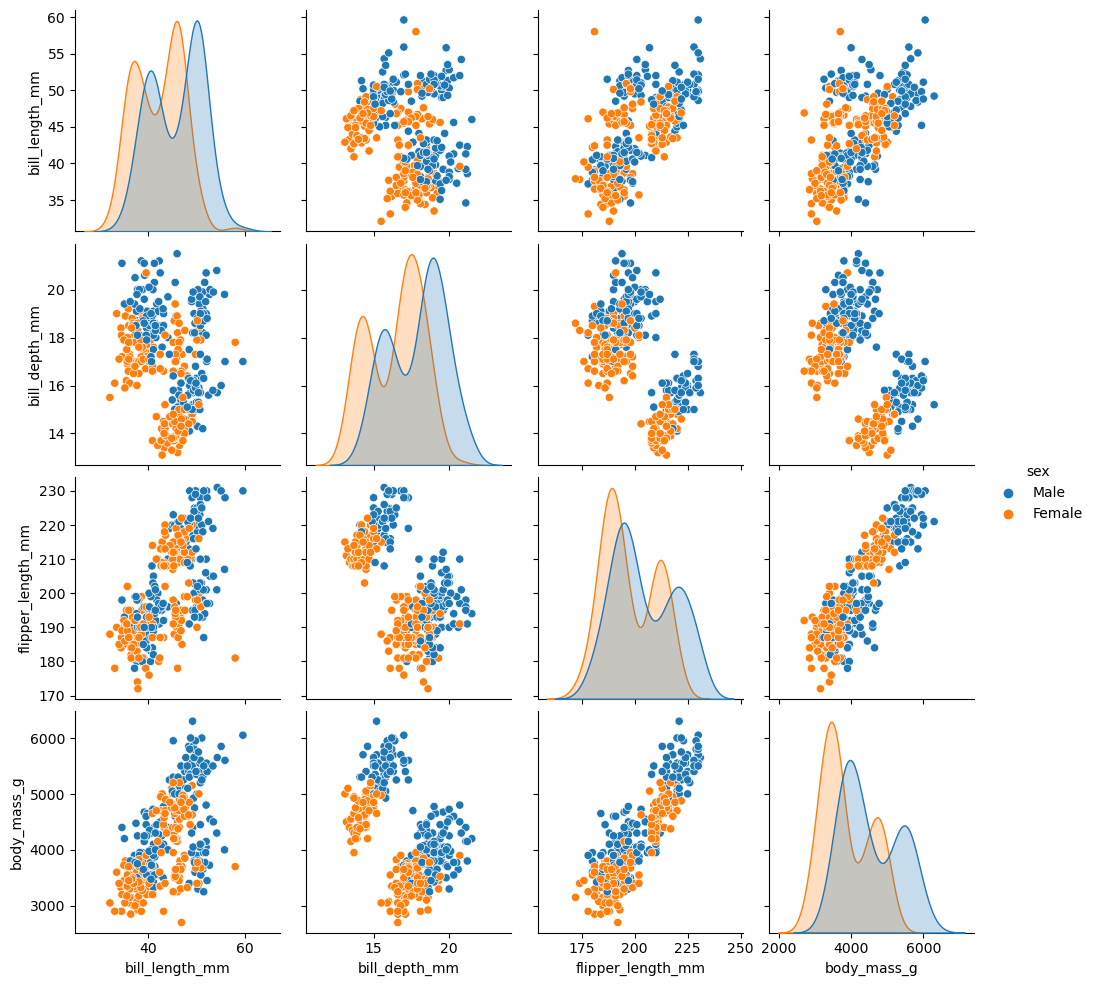

In [8]:
#Numerical value exploration
sns.pairplot(df2, hue="sex")

Numerical things look pretty OK. What about categorical?

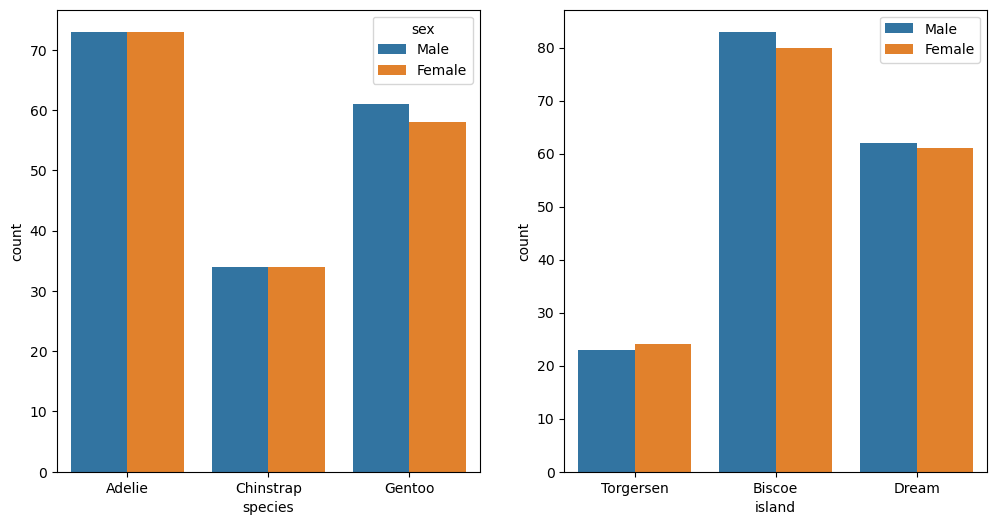

In [9]:
thinkplot.PrePlot(2,1,2)
sns.countplot(data=df2, x="species", hue="sex")
thinkplot.SubPlot(2)
sns.countplot(data=df2, x="island", hue="sex")
thinkplot.Config()

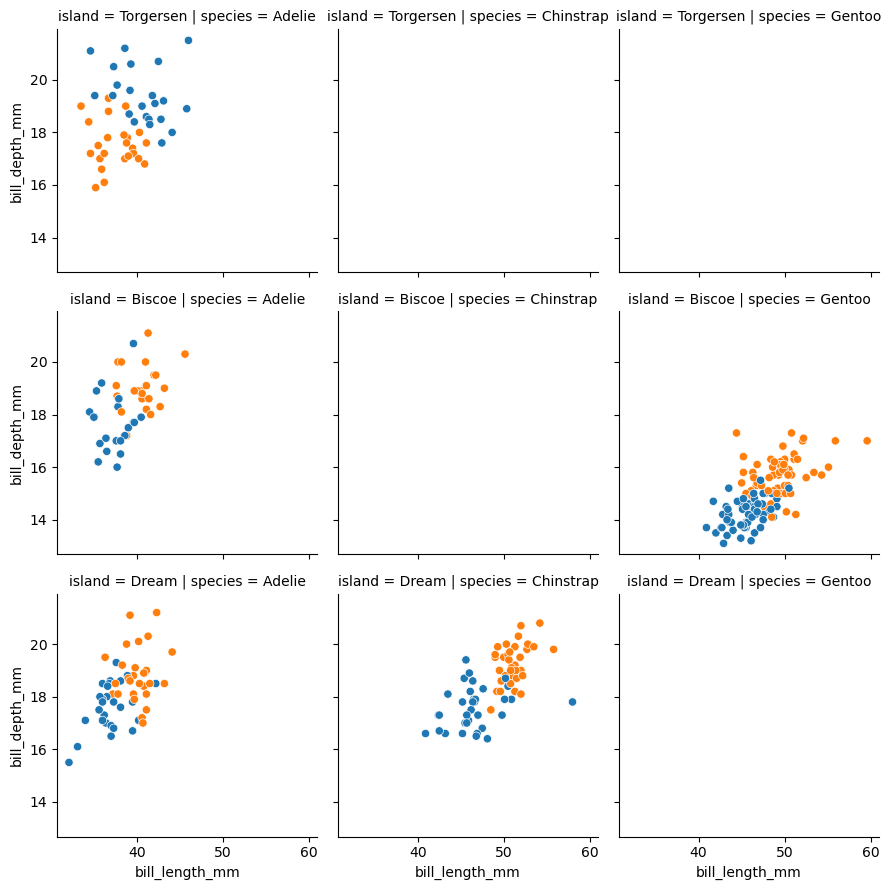

In [10]:
#Facetgrid allows us to explore and split data easily. 
#Could play with this for differnet views. https://seaborn.pydata.org/generated/seaborn.FacetGrid.html 
#Col and row in the first line are our categoricals.
#Second line is the type of chart, and its relevent details. 
g = sns.FacetGrid(df2, col="species", row="island")
g.map_dataframe(sns.scatterplot, x="bill_length_mm", y="bill_depth_mm", hue="sex")

Nothing looks too odd in the exploration (this is a toy dataset, so that's normal). We can do some modelling and predict sex...

I will sklearn, because I like it more. Statsmodels imight be useful in a bit, we could throw it in to get p values for the variables. 

In [ ]:
#Encode the categorical varaiables. 
df2_ = pd.get_dummies(df2, drop_first=True)
df2_.head()

In [ ]:
df2_.info()

In [ ]:
#Make arrays from data
dfYP = df2_["sex_Male"]
dfXP = df2_.drop(columns={"sex_Male"}) #There isn't generally a need to standardize the Y values

xP = np.array(dfXP)
yP = np.array(dfYP).reshape(-1,1)
xP.shape, yP.shape

In [ ]:
#Split Data
X_trainP, X_testP, y_trainP, y_testP = train_test_split(xP, yP, test_size=0.33)

In [ ]:
#Scale data
scalerP = MinMaxScaler()

#Use training data to fit the scaler, then apply that predefined scale to the test data
x2P = scalerP.fit_transform(X_trainP)
X_transP = scalerP.transform(X_testP)

In [ ]:
#Model 
modelP = LogisticRegression().fit(x2P,y_trainP.ravel())

In [ ]:
#Compare to baseline
df2["sex"].value_counts()

Baseline is roughly 50/50, how'd we do? 

In [ ]:
#Make predictions and examine accuracy
predsP = modelP.predict(X_transP)

labelsP = convert_prob_to_label(np.array(predsP))
conf_matrixP = confusion_matrix(y_testP,labelsP)
sns.heatmap(conf_matrixP, annot=True)

print("F1:",f1_score(y_testP, labelsP))
print("Acc:",accuracy_score(y_testP, labelsP))

We're doing pretty well. What could be better? 

One suspicion I have would be that the species are somewhat different. Gentoo in particular seems to have different metrics, so maybe we'd predict it separately? I might need more data for that. 

Also, can we improve by removing confounding vars? Look at StatsModels to have an idea of variable relevance. 

In [11]:
#Encode all data
dfP_ = pd.get_dummies(data=df2, drop_first=True)
dfP_.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
0,39.1,18.7,181.0,3750.0,0,0,0,1,1
1,39.5,17.4,186.0,3800.0,0,0,0,1,0
2,40.3,18.0,195.0,3250.0,0,0,0,1,0
4,36.7,19.3,193.0,3450.0,0,0,0,1,0
5,39.3,20.6,190.0,3650.0,0,0,0,1,1


In [ ]:
#I'm not going to split data, all I want is variable importance, I'm not evaluating accuracy here. 
formP = "sex_Male ~ bill_length_mm + bill_depth_mm + flipper_length_mm + body_mass_g + species_Chinstrap + species_Gentoo + island_Dream + island_Torgersen"
modelP_SM = sm.logit(data=dfP_, formula=formP).fit()
modelP_SM.summary()

I'll remove island and flipper length, try again, and see what's up...

In [ ]:
#Drop the things that look least useful. 
dfXP2 = df2_.drop(columns={"sex_Male", "flipper_length_mm", "island_Dream", "island_Torgersen"}) 

#Make arrays from new data, check shapes
xP2 = np.array(dfXP2)
xP2.shape, yP.shape

In [ ]:
#Split Data
X_trainP2, X_testP2, y_trainP2, y_testP2 = train_test_split(xP2, yP, test_size=0.33)

In [ ]:
#Scale data
scalerP2 = MinMaxScaler()

#Use training data to fit the scaler, then apply that predefined scale to the test data
x2P2 = scalerP2.fit_transform(X_trainP2)
X_transP2 = scalerP2.transform(X_testP2)

In [ ]:
#Model 
modelP2 = LogisticRegression().fit(x2P2,y_trainP2.ravel())

In [ ]:
#Make predictions and examine accuracy
predsP2 = modelP2.predict(X_transP2)

labelsP2 = convert_prob_to_label(np.array(predsP2))
conf_matrixP2 = confusion_matrix(y_testP2,labelsP2)
sns.heatmap(conf_matrixP, annot=True)

print("F1:",f1_score(y_testP2, labelsP2))
print("Acc:",accuracy_score(y_testP2, labelsP2))

Looks good!

Note: We have relatively little data, so the swings for accuracy between trials can be pretty pronounced. The first time I ran this there was a big improvement in accuracy after removing stuff, other runs had a smaller difference. More data would make it more stable, repeating the trials would also. You could build a loop to repeat trials, we'll do it the sklearn way early next semester. 